In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pickle
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
# === PATHS ===
save_dir = "/content/drive/My Drive/stacking_preds/"
data_folder = "/content/drive/My Drive/Normalized3/Final/"

# === Load Predictions ===
def load_pickle(path):
    with open(path, "rb") as f:
        return pickle.load(f)

y_pred_tf = load_pickle(os.path.join(save_dir, "Multi_Head.pkl"))
y_pred_patchtst = load_pickle(os.path.join(save_dir, "patchtst2.pkl"))
y_pred_resnet = load_pickle(os.path.join(save_dir, "resnet_preds.pkl"))

# === Load True Labels ===
file_names = sorted(os.listdir(data_folder))
y_true = [int(f.split("_")[-1].split(".")[0]) for f in file_names if f.endswith(".csv")]
y_true = np.array(y_true)

# === Stack Predictions ===
X_stacked = np.column_stack((y_pred_tf, y_pred_patchtst, y_pred_resnet))


In [ ]:
k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

fold_accuracies = []
all_y_true = []
all_y_pred = []
all_loglosses = []

print(f"\nPerforming {k}-Fold Cross Validation...")

for fold, (train_index, test_index) in enumerate(skf.split(X_stacked, y_true)):


    X_train, X_test = X_stacked[train_index], X_stacked[test_index]
    y_train, y_test = y_true[train_index], y_true[test_index]

    # Convert to DMatrix
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    # Store evaluation results
    evals_result = {}

    # Set parameters
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'max_depth': 6,
        'learning_rate': 0.1,
    }

    # Train
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=100,
        evals=[(dtest, 'validation')],
        evals_result=evals_result,
        verbose_eval=False
    )

    # Predict and evaluate
    y_pred = model.predict(dtest)
    y_pred_binary = (y_pred > 0.5).astype(int)

    fold_acc = accuracy_score(y_test, y_pred_binary)
    fold_accuracies.append(fold_acc)
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred_binary)
    all_loglosses.append(evals_result['validation']['logloss'])



Performing 5-Fold Cross Validation...


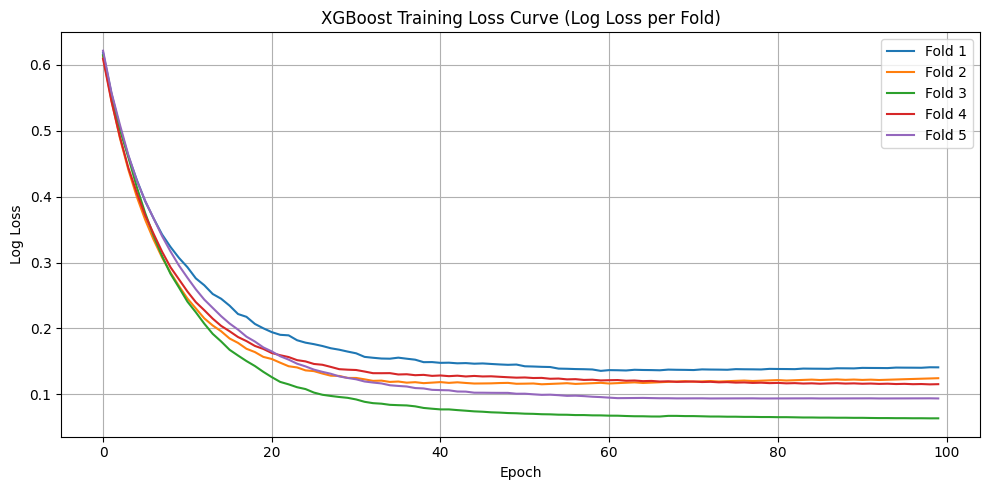

In [ ]:
plt.figure(figsize=(10, 5))
for i, logloss in enumerate(all_loglosses):
    plt.plot(logloss, label=f"Fold {i+1}")
plt.xlabel("Epoch")
plt.ylabel("Log Loss")
plt.title("XGBoost Training Loss Curve (Log Loss per Fold)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


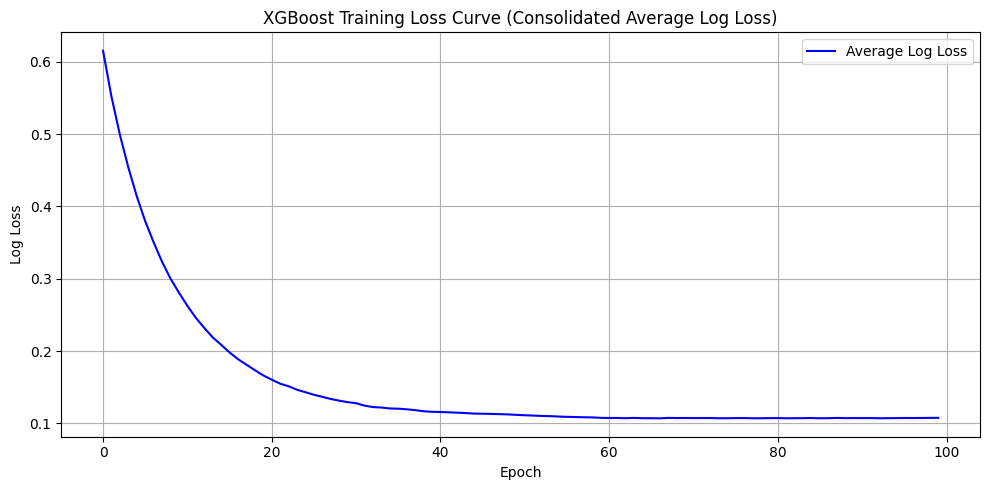

In [ ]:
# Compute the average log loss over all folds for each epoch
average_logloss = np.mean(all_loglosses, axis=0)
# Plot the consolidated (average) log loss curve
plt.figure(figsize=(10, 5))
plt.plot(average_logloss, label="Average Log Loss", color='b')
plt.xlabel("Epoch")
plt.ylabel("Log Loss")
plt.title("XGBoost Training Loss Curve (Consolidated Average Log Loss)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



Average Fold Accuracy (5-Fold): 0.9695

Overall Classification Report:
              precision    recall  f1-score   support

      Absent       0.97      0.98      0.97        87
     Present       0.97      0.96      0.97        77

    accuracy                           0.97       164
   macro avg       0.97      0.97      0.97       164
weighted avg       0.97      0.97      0.97       164



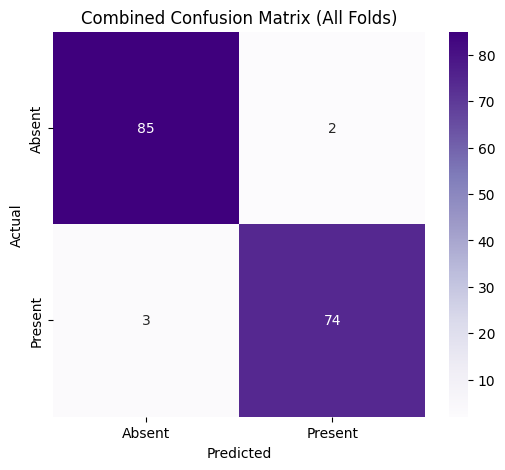

In [ ]:
avg_acc = np.mean(fold_accuracies)
print(f"\nAverage Fold Accuracy (5-Fold): {avg_acc:.4f}")

print("\nOverall Classification Report:")
print(classification_report(all_y_true, all_y_pred, target_names=["Absent", "Present"]))

cm_total = confusion_matrix(all_y_true, all_y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_total, annot=True, fmt="d", cmap="Purples", xticklabels=["Absent", "Present"], yticklabels=["Absent", "Present"])
plt.title("Combined Confusion Matrix (All Folds)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
# === MODEL SUMMARY AND COMPLETE FLOPs ESTIMATION ===

print("XGBoost Model Summary")
print(f"Number of Trees       : {xgb_model.n_estimators}")
print(f"Max Depth             : {xgb_model.max_depth}")
print(f"Learning Rate         : {xgb_model.learning_rate}")
print(f"Input Features        : {X_stacked.shape[1]}")
print(f"Total Samples         : {X_stacked.shape[0]}")

# Detailed FLOPs estimation
flops_per_tree = 2 * (2 ** xgb_model.max_depth - 1)  # comparisons + decisions per tree
total_flops = xgb_model.n_estimators * flops_per_tree * X_stacked.shape[0]

print(f"\nEstimated FLOPs (All Trees, All Samples): {total_flops:,}")


XGBoost Model Summary
Number of Trees       : 100
Max Depth             : 6
Learning Rate         : 0.1
Input Features        : 3
Total Samples         : 164

Estimated FLOPs (All Trees, All Samples): 2,066,400
